In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np

# Fetch data from two directories

Since we have `results_20240126/` and `results_20240131/` stored in S3 bucket, and they have overlapping `JSON` files. After some investigation, the only difference between the data in `results_20240126/` and `results_20240131/` for the same project is the `timestamp` of creation and the order of imports. Therefore, we combine data from two directories and simply choose the data from the latter directory if both directories have it.

In [2]:
# Directories containing JSON files for each project
project_directory_1 = "../experiments/biomedical_projects_experiment/results_20240126/"
project_directory_2 = "../experiments/biomedical_projects_experiment/results_20240131/"

In [69]:
# List of import patterns to store DataFrames for each project
project_dfs_metadata = []
project_dfs_codedirs = []
project_dfs_deps = []
project_dfs_imports = []

In [70]:
# Iterate through JSON files in the directory
for filename in set(os.listdir(project_directory_1) + os.listdir(project_directory_2)):

    file_path_1 = os.path.join(project_directory_1, filename)
    file_path_2 = os.path.join(project_directory_2, filename)

    file_path = file_path_1 if os.path.exists(file_path_1) else file_path_2

    # Load JSON data from the file
    with open(file_path, "r") as file:
        project_data = json.load(file)

    # Extract data from the project_data
    metadata = project_data.get("metadata", {})
    codedirs = project_data.get("code_dirs", {})
    deps_list = project_data.get("deps_file", [])
    imports_list = project_data.get("imports", [])

    metadata_list = [metadata]
    metadata_data = pd.DataFrame(metadata_list)

    project_dfs_metadata.append(metadata_data)

    # Create a list of dictionaries of code directories
    if codedirs:
        codedirs_dicts = [
            {
                "code directory": key,
                ".py count": value["py"],
                ".ipynb count": value["ipynb"],
                "count": value["total"],
            }
            for key, value in codedirs.items()
        ]
    else:
        codedirs_dicts = [
            {
                "code directory": None,
                ".py count": 0,
                ".ipynb count": 0,
                "count": 0,
            }
        ]

    # Create a DataFrame from the list of dictionaries
    codedirs_data = pd.DataFrame(codedirs_dicts)
    codedirs_data["project_name"] = metadata.get("project_name")

    # Append the DataFrame to the list
    project_dfs_codedirs.append(codedirs_data)

    # Create a list of dictionaries of dependency declaration files
    deps_dicts = [
        {
            "parser_choice": dep_data["parser_choice"],
            "path": dep_data["path"],
            "deps_count": dep_data["deps_count"],
            "warnings": dep_data["warnings"],
        }
        for dep_data in deps_list
        if deps_list
    ]

    if not deps_list:
        deps_dicts = [
            {
                "parser_choice": None,
                "path": None,
                "deps_count": None,
                "warnings": None,
            }
        ]

    # Create a DataFrame from the list of dictionaries
    deps_data = pd.DataFrame(deps_dicts)
    deps_data["project_name"] = metadata.get("project_name")

    # Append the DataFrame to the list
    project_dfs_deps.append(deps_data)

    # Create a list of dictionaries of imports
    def _process_import_data(import_data):
        import_type = list(import_data.keys())[0]
        # Combine primary alternative and alternative imports into a single alternative import type
        display_import_type = import_type.removesuffix(" (primary)")
        import_dict = {
            "import_type": display_import_type,
            "name": import_data[import_type]["name"],
            "lineno": import_data[import_type]["source"]["lineno"],
        }
        return import_dict

    imports_dicts = [_process_import_data(import_data) for import_data in imports_list]

    # Create a DataFrame from the list of dictionaries
    imports_data = pd.DataFrame(imports_dicts)
    imports_data["project_name"] = metadata.get("project_name")

    # Append the DataFrame to the list
    project_dfs_imports.append(imports_data)

# Combine all project DataFrames into a single DataFrame
df_metadata = pd.concat(project_dfs_metadata, ignore_index=True)
df_codedirs = pd.concat(project_dfs_codedirs, ignore_index=True)
df_deps = pd.concat(project_dfs_deps, ignore_index=True)
df_imports = pd.concat(project_dfs_imports, ignore_index=True)

# Data cleaning
There are some projects that don't have any Python code (`.py` or `.ipynb` files) at all, and they are obviously not in our scope.

In [5]:
df_codedirs_no_code = df_codedirs[df_codedirs["code directory"].isna()]
df_codedirs_no_code

,code directory,.py count,.ipynb count,count,project_name
62,None,0,0,0,methylation450KPipeline
65,None,0,0,0,pcev_pipelineCBRAIN
80,None,0,0,0,cytoscape.js
81,None,0,0,0,ghi
151,None,0,0,0,VivaGraphJS
...,...,...,...,...,...
26944,None,0,0,0,docker-apollo
26945,None,0,0,0,examples
27009,None,0,0,0,cbrain-plugins-psom
27010,None,0,0,0,disease_sims


In [6]:
df_codedirs_clean = df_codedirs[~df_codedirs["code directory"].isna()]
df_deps_clean = df_deps[
    ~df_deps["project_name"].isin(df_codedirs_no_code["project_name"])
]
df_imports_clean = df_imports[
    ~df_imports["project_name"].isin(df_codedirs_no_code["project_name"])
]

In [7]:
# In fact, there's no need to do `df_imports_clean` because there are no imports detected if there are no Python code :)
df_imports[df_imports["project_name"].isin(df_codedirs_no_code["project_name"])]

,import_type,name,lineno,project_name


# Analysis
## Code directories

In [8]:
# Number of projects
df_codedirs_clean["project_name"].nunique()

1830

### Count of code directories
The count of code directories stands for the complexity of the project.

In [9]:
# Count of directories containing Python code per project
count_df_codedirs = (
    df_codedirs_clean.groupby("project_name").size().reset_index(name="codedirs_count")
)

In [10]:
count_df_codedirs

,project_name,codedirs_count
0,1kp,3
1,2013-khmer-counting,2
2,2018_Bacterial_Pipeline_riboseq,1
3,2018_ecoli_pathogenicity,2
4,2018koyeast,3
...,...,...
1825,xray-thc,2
1826,yapic,4
1827,yarl,5
1828,yeadon,6


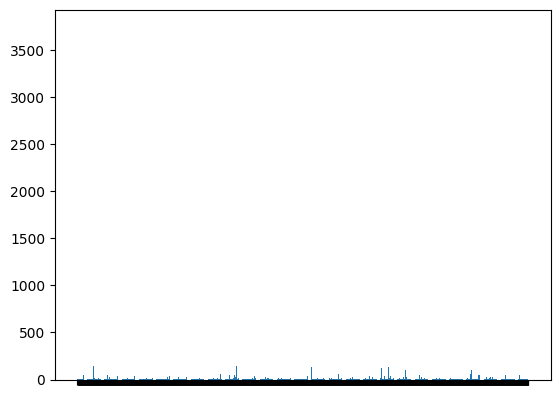

In [11]:
plt.bar("project_name", "codedirs_count", data=count_df_codedirs)
plt.gca().set_xticklabels([])
plt.show()

In [12]:
# There are some projects that have over 400 directories containing Python code
count_df_codedirs[count_df_codedirs["codedirs_count"] > 400]

,project_name,codedirs_count
509,airflow,1157
654,checkov,608
922,google-cloud-python,3740
1525,ray,632
1743,transformers,637


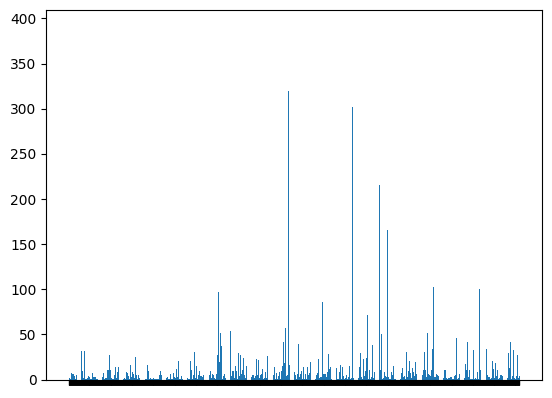

In [124]:
plt.bar(
    "project_name",
    "codedirs_count",
    data=count_df_codedirs[count_df_codedirs["codedirs_count"] < 400],
)
plt.gca().set_xticklabels([])
plt.show()

#### Example: airflow

In [14]:
df_codedirs_airflow = df_codedirs_clean[df_codedirs_clean["project_name"] == "airflow"]

In [15]:
df_codedirs_airflow[df_codedirs_airflow["code directory"].str.contains("test")]

,code directory,.py count,.ipynb count,count,project_name
17420,tests/system/providers/amazon/aws,59,0,59,airflow
17422,tests/dags,50,0,50,airflow
17423,tests/providers/google/cloud/hooks,50,0,50,airflow
17424,tests/providers/google/cloud/operators,46,0,46,airflow
17427,tests/providers/amazon/aws/hooks,46,0,46,airflow
...,...,...,...,...,...
18569,tests/providers/fab/auth_manager/api/auth,1,0,1,airflow
18571,tests/providers/jdbc,1,0,1,airflow
18572,tests/system/providers/dbt,1,0,1,airflow
18573,tests/providers/dbt/cloud/test_data,1,0,1,airflow


In [16]:
df_codedirs_airflow[df_codedirs_airflow["code directory"].str.contains("script")]

,code directory,.py count,.ipynb count,count,project_name
17419,scripts/ci/pre_commit,68,0,68,airflow
17482,scripts/in_container,13,0,13,airflow
17559,scripts/cov,5,0,5,airflow
17604,scripts/tools,4,0,4,airflow
18325,scripts/ci/testing,1,0,1,airflow


### Main code directory

In [17]:
df_codedirs_main_code = df_codedirs_clean[
    ~df_codedirs_clean["code directory"].str.contains("test")
    & ~df_codedirs_clean["code directory"].str.contains("example")
    & ~df_codedirs_clean["code directory"].str.contains("sample")
    & (
        ~df_codedirs_clean["code directory"].str.contains("doc")
        | df_codedirs_clean["code directory"].str.contains("docker")
        | df_codedirs_clean["code directory"].str.contains("docstring")
    )
]
df_codedirs_main_code

,code directory,.py count,.ipynb count,count,project_name
0,.,0,12,12,Spatially-resolved-3D-metabolomic-profiling
1,.,1,3,4,NanoDrugsMalaria
2,Analysis_Notebooks,1,25,26,TCGA
3,src/Figures,7,0,7,TCGA
4,src/Data,7,0,7,TCGA
...,...,...,...,...,...
27028,flu-forecasting/scripts,9,0,9,seasonal-flu
27029,flu-forecasting/src,4,0,4,seasonal-flu
27030,flu-forecasting/src/forecast,3,0,3,seasonal-flu
27031,notebooks,0,3,3,seasonal-flu


In [18]:
df_codedirs_max = df_codedirs_main_code.loc[
    df_codedirs_main_code.groupby("project_name")["count"].idxmax()
]

#### Note: there are some projects where the Python code are only stored in `test`, `example`, `sample`, or `doc` files.

In [19]:
xxx = df_codedirs_clean[~df_codedirs_clean["project_name"].duplicated()]
xxx[~xxx["project_name"].isin(df_codedirs_max["project_name"])]

,code directory,.py count,.ipynb count,count,project_name
1123,cytoscape-automation-example,0,2,2,PathLinker-Cytoscape
1394,docs,1,0,1,Swift-T-Variant-Calling
1937,examples/full-demo,1,0,1,ten-simple-rules-dockerfiles
2024,examples,0,2,2,Polymake.jl
2576,tests,1,0,1,mockrobiota
5056,tests,1,1,2,npy-matlab
6355,docs/eforge-db-construction,3,0,3,eFORGE
6433,docs/acr_project,0,2,2,NiftyPET
6767,python_tests,3,0,3,diffusion
6998,doc/tutorial/eXamineNotebook,0,2,2,eXamine


In [20]:
# Divide projects into three groups by code directory patterns
same_name_projects = df_codedirs_max[
    df_codedirs_max["code directory"] == df_codedirs_max["project_name"]
]["project_name"].tolist()

src_projects = df_codedirs_max.dropna()[
    df_codedirs_max.dropna()["code directory"].str.startswith("src")
]["project_name"].tolist()

root_dir_projects = df_codedirs_max[df_codedirs_max["code directory"] == "."][
    "project_name"
].tolist()

rest_projects = df_codedirs_max[
    ~df_codedirs_max["project_name"].isin(
        same_name_projects + src_projects + root_dir_projects
    )
]["project_name"].tolist()

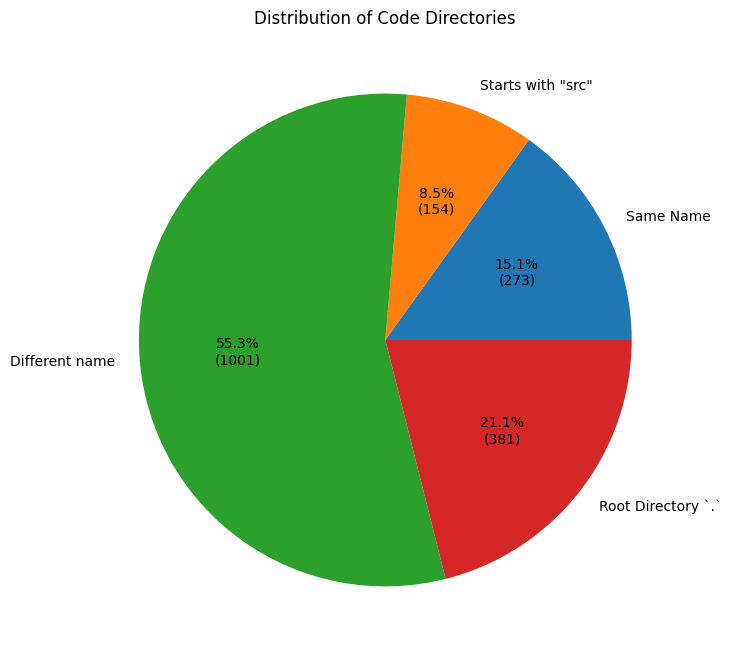

In [21]:
# Create a DataFrame for plotting
plot_data = pd.DataFrame(
    {
        "Category": [
            "Same Name",
            'Starts with "src"',
            "Different name",
            "Root Directory `.`",
        ],
        "Percentage": [
            len(same_name_projects),
            len(src_projects),
            len(rest_projects),
            len(root_dir_projects),
        ],
        "Projects": [
            same_name_projects,
            src_projects,
            rest_projects,
            root_dir_projects,
        ],
    }
)


def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return "{:.1f}%\n({v:d})".format(pct, v=val)

    return my_format


# Plotting as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    plot_data["Percentage"],
    labels=plot_data.apply(lambda x: f"{x['Category']}", axis=1),
    autopct=autopct_format(plot_data["Percentage"]),
)
plt.title("Distribution of Code Directories")
plt.show()

## Dependency declaration files

In [22]:
df_deps_clean

,parser_choice,path,deps_count,warnings,project_name
0,None,None,None,None,Spatially-resolved-3D-metabolomic-profiling
1,None,None,None,None,NanoDrugsMalaria
2,None,None,None,None,TCGA
3,requirements.txt,requirements.txt,15,False,httpx
4,pyproject.toml,pyproject.toml,12,False,httpx
...,...,...,...,...,...
5103,None,None,None,None,JessEV
5104,requirements.txt,requirements.txt,6,False,expipe
5105,requirements.txt,docs/requirements.txt,2,False,expipe
5106,setup.py,setup.py,0,True,expipe


In [84]:
# Divide projects into three groups by parser choice
project_req_txt = set(
    df_deps_clean[df_deps_clean["parser_choice"] == "requirements.txt"]["project_name"]
)
project_req_txt_no_deps = set(
    df_deps_clean[df_deps_clean["parser_choice"] == "requirements.txt"].loc[
        df_deps_clean["deps_count"] == 0
    ]
["project_name"]
)
project_pyproject_toml = set(
    df_deps_clean[df_deps_clean["parser_choice"] == "pyproject.toml"]["project_name"]
)
project_pyproject_toml_no_deps = set(
    df_deps_clean[df_deps_clean["parser_choice"] == "pyproject.toml"].loc[
        df_deps_clean["deps_count"] == 0
    ]["project_name"]
)
project_setup = set(
    df_deps_clean.dropna()[
        df_deps_clean.dropna()["parser_choice"].str.startswith("setup")
    ]["project_name"]
)
project_no_deps = set(
    df_deps_clean[df_deps_clean["parser_choice"].isnull()]["project_name"]
)

In [85]:
project_req_only = project_req_txt - project_pyproject_toml - project_setup
project_toml_only = project_pyproject_toml - project_req_txt - project_setup
project_setup_only = project_setup - project_req_txt - project_pyproject_toml
project_req_toml = project_req_txt.intersection(
    project_pyproject_toml
) - project_req_txt.intersection(project_pyproject_toml).intersection(project_setup)
project_req_setup = project_req_txt.intersection(
    project_setup
) - project_req_txt.intersection(project_pyproject_toml).intersection(project_setup)
project_toml_setup = project_pyproject_toml.intersection(
    project_setup
) - project_req_txt.intersection(project_pyproject_toml).intersection(project_setup)
project_req_toml_setup = project_req_txt.intersection(
    project_pyproject_toml
).intersection(project_setup)

In [86]:
df_deps_count = pd.DataFrame(
    dict(
        type_=[
            "requirements.txt only",
            "pyproject.toml only",
            "setup.py/setup.cfg only",
            "requirements.txt and pyproject.toml",
            "requirements.txt and setup.py/setup.cfg",
            "pyproject.toml and setup.py/setup.cfg",
            "requirements.txt, pyproject.toml and setup.py/setup.cfg",
            "no dependency declaration files",
        ],
        count=[
            len(project_req_only),
            len(project_toml_only),
            len(project_setup_only),
            len(project_req_toml),
            len(project_req_setup),
            len(project_toml_setup),
            len(project_req_toml_setup),
            len(project_no_deps),
        ],
    )
)

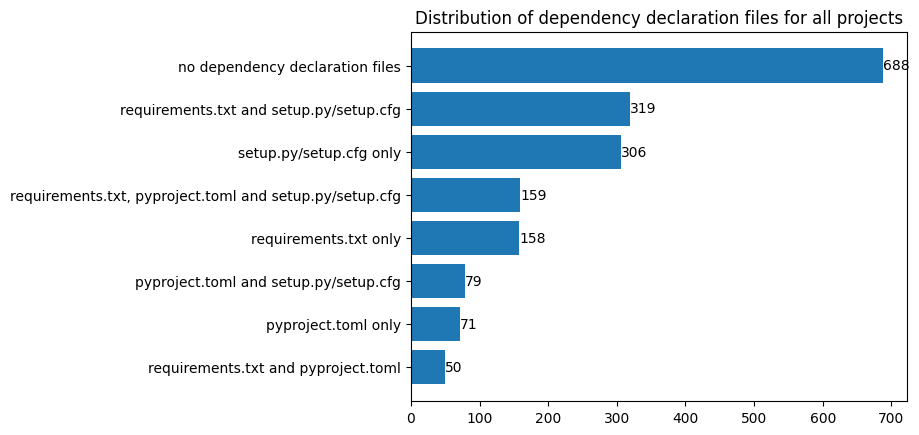

In [87]:
df_deps_count_sorted = df_deps_count.sort_values("count")
fig, ax = plt.subplots()
bars = plt.barh("type_", "count", data=df_deps_count_sorted)

ax.bar_label(bars)
plt.title("Distribution of dependency declaration files for all projects")
plt.show()

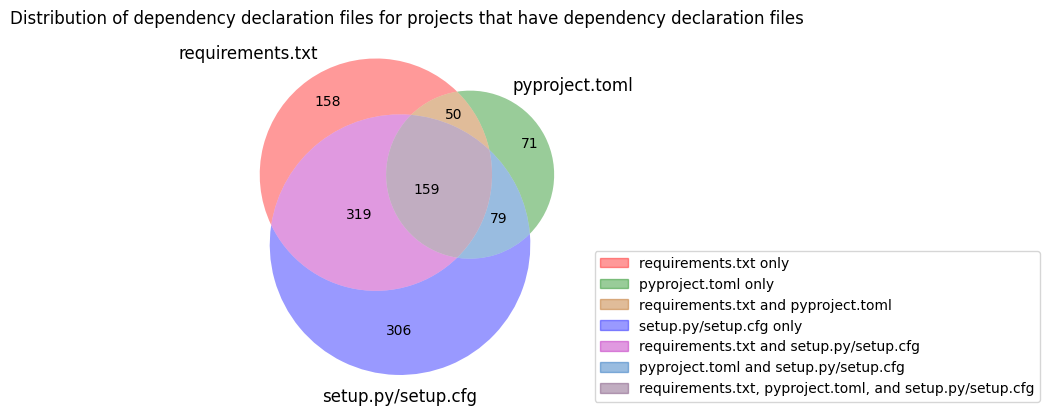

In [88]:
# Draw a venn diagram
plt.figure()
ax = plt.gca()

set_1_name = "requirements.txt"
set_2_name = "pyproject.toml"
set_3_name = "setup.py/setup.cfg"

venn_parsers = venn3(
    [project_req_txt, project_pyproject_toml, project_setup],
    set_labels=(set_1_name, set_2_name, set_3_name),
    ax=ax,
)

# Define labels for all sets and intersections
# for a 3-circle diagram, the sequence is 100, 010, 110, 001, 101, 011, 111
legend_labels = [
    f"{set_1_name} only",
    f"{set_2_name} only",
    f"{set_1_name} and {set_2_name}",
    f"{set_3_name} only",
    f"{set_1_name} and {set_3_name}",
    f"{set_2_name} and {set_3_name}",
    f"{set_1_name}, {set_2_name}, and {set_3_name}",
]

legend_handles = [
    Patch(
        color=patch.get_facecolor(),
        label=legend_labels[venn_parsers.patches.index(patch)],
    )
    for patch in venn_parsers.patches
    if patch
]

plt.legend(handles=legend_handles, loc=(1.04, 0))
plt.title(
    "Distribution of dependency declaration files for projects that have dependency declaration files"
)
plt.show()

## Import patterns

In [89]:
df_imports_clean.head()

,import_type,name,lineno,project_name
0,Regular,tifffile,2.0,Spatially-resolved-3D-metabolomic-profiling
1,Regular,numpy,3.0,Spatially-resolved-3D-metabolomic-profiling
2,Regular,matplotlib,5.0,Spatially-resolved-3D-metabolomic-profiling
3,Regular,matplotlib,6.0,Spatially-resolved-3D-metabolomic-profiling
4,Regular,PIL,7.0,Spatially-resolved-3D-metabolomic-profiling


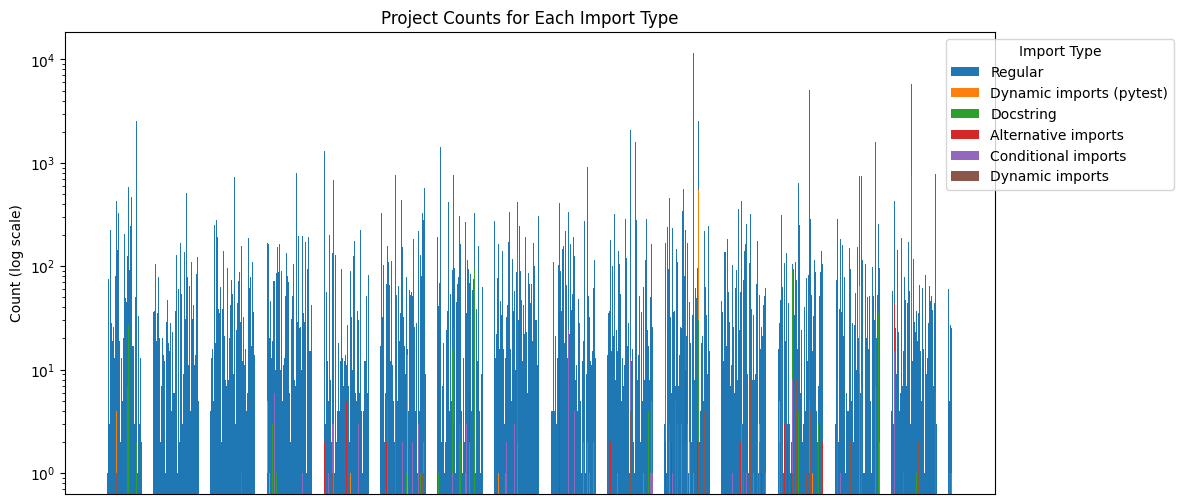

In [29]:
# Create a bar plot for the counts of each import type
frame = plt.figure(figsize=(12, 6))

# Iterate over unique import types and plot a bar for each
for import_type in df_imports_clean["import_type"].unique():
    import_type_data = df_imports_clean[df_imports_clean["import_type"] == import_type]
    project_counts = import_type_data.groupby("project_name").size()
    plt.bar(project_counts.index, project_counts, label=import_type)
    plt.yscale("log")  # Apply log scale to the y-axis for the plot
    plt.ylabel("Count (log scale)")
    plt.title("Project Counts for Each Import Type")
    plt.legend(title="Import Type", loc="upper right", bbox_to_anchor=(1.2, 1))
    # Hide x axis
    for axis in frame.axes:
        axis.get_xaxis().set_visible(False)

# Set the common x-axis label
plt.xlabel("Project Name")

plt.show()

In [30]:
# Divide projects into three groups by parser choice
project_conditional_imports = set(
    df_imports_clean[df_imports_clean["import_type"] == "Conditional imports"][
        "project_name"
    ]
)
project_alternative_imports = set(
    df_imports_clean[df_imports_clean["import_type"] == "Alternative imports"][
        "project_name"
    ]
)
project_dynamic_imports = set(
    df_imports_clean[df_imports_clean["import_type"] == "Dynamic imports"][
        "project_name"
    ]
)
project_docstring = set(
    df_imports_clean[df_imports_clean["import_type"] == "Docstring"]["project_name"]
)
project_all = set(df_codedirs_clean["project_name"])

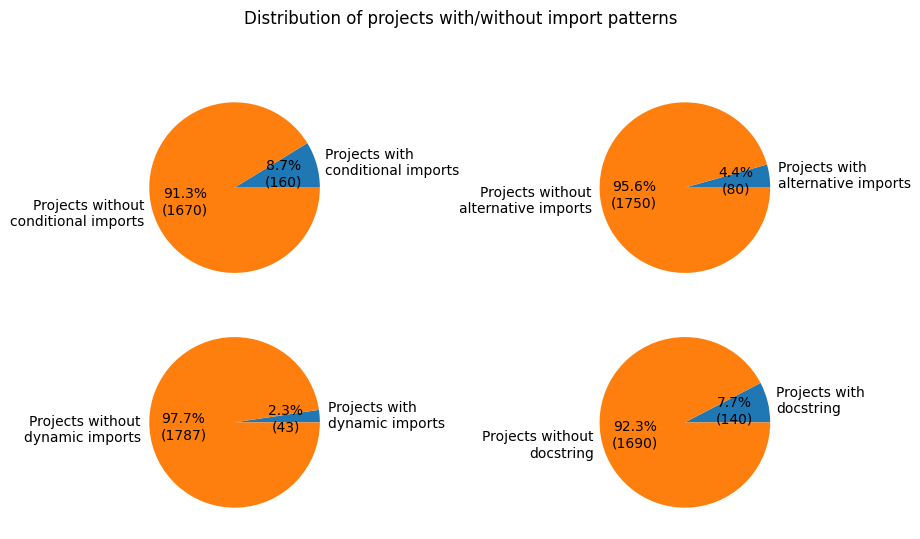

In [31]:
def create_plot_data(import_pattern, import_set):
    return pd.DataFrame(
        {
            "Category": [
                f"Projects with \n{import_pattern}",
                f"Projects without\n{import_pattern}",
            ],
            "Percentage": [
                len(import_set),
                len(project_all) - len(import_set),
            ],
        }
    )


def create_pie_chart(plot_data, axis):
    axis.pie(
        plot_data["Percentage"],
        labels=plot_data.apply(lambda x: f"{x['Category']}", axis=1),
        autopct=autopct_format(plot_data["Percentage"]),
    )


figure, axis = plt.subplots(2, 2, figsize=(9, 6), layout="compressed")

create_pie_chart(
    create_plot_data("conditional imports", project_conditional_imports), axis[0, 0]
)
create_pie_chart(
    create_plot_data("alternative imports", project_alternative_imports), axis[0, 1]
)
create_pie_chart(
    create_plot_data("dynamic imports", project_dynamic_imports), axis[1, 0]
)
create_pie_chart(create_plot_data("docstring", project_docstring), axis[1, 1])

plt.suptitle("Distribution of projects with/without import patterns")
plt.show()

## Correlations

### Code directories whose names are `notebooks`

In [33]:
df_codedirs_clean[df_codedirs_clean["code directory"] == "notebooks"]

,code directory,.py count,.ipynb count,count,project_name
90,notebooks,1,11,12,multi-omics-state-of-the-field
740,notebooks,0,5,5,paper-encoding_decoding_electrophysiology
895,notebooks,0,10,10,pylandstats-notebooks
1112,notebooks,0,7,7,swiss-urbanization
1115,notebooks,0,3,3,ReactomeGSA-tutorials
...,...,...,...,...,...
26409,notebooks,0,7,7,scijava-jupyter-kernel
26494,notebooks,3,15,18,carboxecoli
26742,notebooks,0,15,15,Methanomassilii
26970,notebooks,0,5,5,pore_stats


### Count of Python files in the main code directory VS dependency declarations

In [90]:
conditions = [
    (df_codedirs_max["project_name"].isin(project_req_only)),
    (df_codedirs_max["project_name"].isin(project_toml_only)),
    (df_codedirs_max["project_name"].isin(project_setup_only)),
    (df_codedirs_max["project_name"].isin(project_req_toml)),
    (df_codedirs_max["project_name"].isin(project_req_setup)),
    (df_codedirs_max["project_name"].isin(project_toml_setup)),
    (df_codedirs_max["project_name"].isin(project_req_toml_setup)),
    (df_codedirs_max["project_name"].isin(project_no_deps)),
]

# create a list of the values we want to assign for each condition
values = [
    "requirements.txt only",
    "pyproject.toml only",
    "setup.py/setup.cfg only",
    "requirements.txt and pyproject.toml",
    "requirements.txt and setup.py/setup.cfg",
    "pyproject.toml and setup.py/setup.cfg",
    "requirements.txt, pyproject.toml and setup.py/setup.cfg",
    "no dependency declaration files",
]

# create a new column and use np.select to assign values to it using our lists as arguments
df_codedirs_max["deps"] = np.select(conditions, values)

In [94]:
df_codedirs_max

,code directory,.py count,.ipynb count,count,project_name,deps,.ipynb>=5
1142,scripts/genealignmenttree,6,0,6,1kp,no dependency declaration files,False
1912,pipeline,8,0,8,2013-khmer-counting,no dependency declaration files,False
23205,.,4,3,7,2018_Bacterial_Pipeline_riboseq,no dependency declaration files,False
26141,src,12,0,12,2018_ecoli_pathogenicity,no dependency declaration files,False
1532,notebooks,0,23,23,2018koyeast,no dependency declaration files,True
...,...,...,...,...,...,...,...
13944,data_access_notebooks,0,6,6,xray-thc,requirements.txt only,True
18620,yapic,7,0,7,yapic,setup.py/setup.cfg only,False
16556,packaging/pep517_backend,8,0,8,yarl,pyproject.toml and setup.py/setup.cfg,False
26722,yeadon,9,0,9,yeadon,requirements.txt and setup.py/setup.cfg,False


In [92]:
df_codedirs_max[".ipynb>=5"] = np.where(
    df_codedirs_max[".ipynb count"] >= 5, True, False
)

Text(0.5, 0, 'Python code files count in the main code directory')

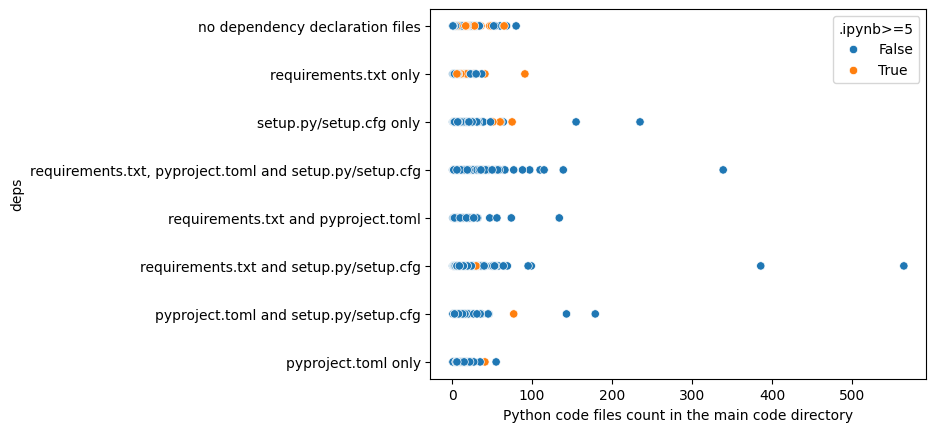

In [96]:
ax = sns.scatterplot(data=df_codedirs_max, x="count", y="deps", hue=".ipynb>=5")
ax.set_xlabel("Python code files count in the main code directory")

In [97]:
df_codedirs_max[df_codedirs_max["count"] > 200]

,code directory,.py count,.ipynb count,count,project_name,deps,.ipynb>=5
6449,sdks/python/client/argo_workflows/model,386,0,386,argo,requirements.txt and setup.py/setup.cfg,False
4384,Tests,235,0,235,biopython,setup.py/setup.cfg only,False
24887,checkov/terraform/checks/resource/aws,339,0,339,checkov,"requirements.txt, pyproject.toml and setup.py/...",False
1593,kubernetes/client/models,565,0,565,python,requirements.txt and setup.py/setup.cfg,False


### Number of directories containing Python files VS dependency declarations

In [98]:
count_df_codedirs

,project_name,codedirs_count
0,1kp,3
1,2013-khmer-counting,2
2,2018_Bacterial_Pipeline_riboseq,1
3,2018_ecoli_pathogenicity,2
4,2018koyeast,3
...,...,...
1825,xray-thc,2
1826,yapic,4
1827,yarl,5
1828,yeadon,6


In [118]:
conditions = [
    (count_df_codedirs["project_name"].isin(project_req_only)),
    (count_df_codedirs["project_name"].isin(project_toml_only)),
    (count_df_codedirs["project_name"].isin(project_setup_only)),
    (count_df_codedirs["project_name"].isin(project_req_toml)),
    (count_df_codedirs["project_name"].isin(project_req_setup)),
    (count_df_codedirs["project_name"].isin(project_toml_setup)),
    (count_df_codedirs["project_name"].isin(project_req_toml_setup)),
    (count_df_codedirs["project_name"].isin(project_no_deps)),
]

# create a list of the values we want to assign for each condition
values = [
    "requirements.txt only",
    "pyproject.toml only",
    "setup.py/setup.cfg only",
    "requirements.txt and pyproject.toml",
    "requirements.txt and setup.py/setup.cfg",
    "pyproject.toml and setup.py/setup.cfg",
    "requirements.txt, pyproject.toml and setup.py/setup.cfg",
    "no dependency declaration files",
]

desired_order = [
    "no dependency declaration files",
    "requirements.txt only",
    "pyproject.toml only",
    "setup.py/setup.cfg only",
    "requirements.txt and pyproject.toml",
    "requirements.txt and setup.py/setup.cfg",
    "pyproject.toml and setup.py/setup.cfg",
    "requirements.txt, pyproject.toml and setup.py/setup.cfg",
]


# create a new column and use np.select to assign values to it using our lists as arguments
count_df_codedirs["deps"] = np.select(conditions, values)


In [120]:
count_df_codedirs["deps"] = pd.Categorical(count_df_codedirs["deps"], categories=desired_order, ordered=True)

In [121]:
count_df_codedirs

,project_name,codedirs_count,deps
0,1kp,3,no dependency declaration files
1,2013-khmer-counting,2,no dependency declaration files
2,2018_Bacterial_Pipeline_riboseq,1,no dependency declaration files
3,2018_ecoli_pathogenicity,2,no dependency declaration files
4,2018koyeast,3,no dependency declaration files
...,...,...,...
1825,xray-thc,2,requirements.txt only
1826,yapic,4,setup.py/setup.cfg only
1827,yarl,5,pyproject.toml and setup.py/setup.cfg
1828,yeadon,6,requirements.txt and setup.py/setup.cfg


Text(0.5, 0, 'Count of directories containing Python files')

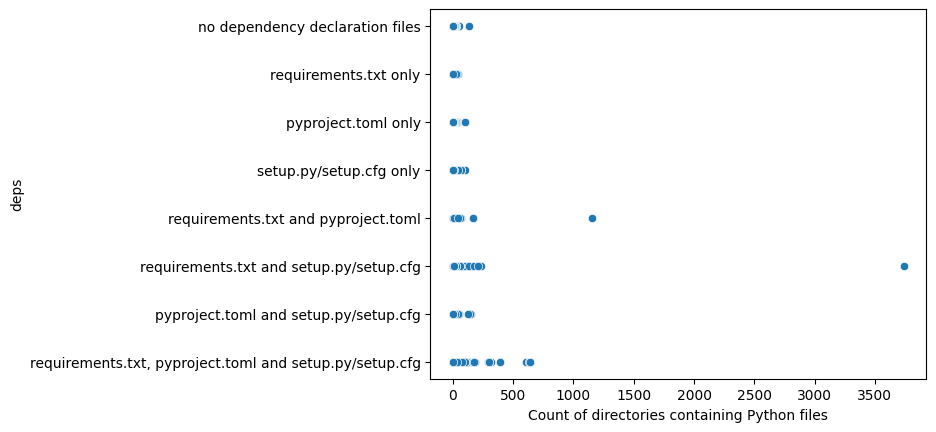

In [122]:
ax = sns.scatterplot(data=count_df_codedirs, x="codedirs_count", y="deps")
ax.set_xlabel("Count of directories containing Python files")


Text(0.5, 0, 'Count of directories containing Python files')

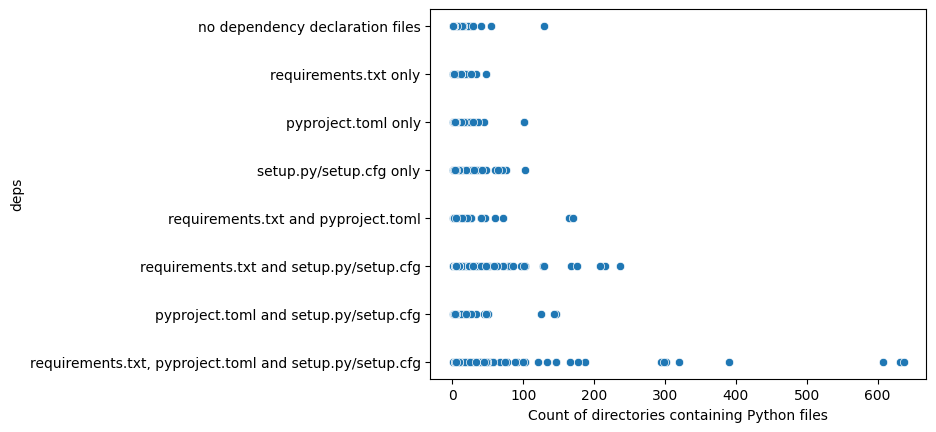

In [123]:
ax = sns.scatterplot(data=count_df_codedirs[count_df_codedirs["codedirs_count"]<1000]
, x="codedirs_count", y="deps")
ax.set_xlabel("Count of directories containing Python files")

In [114]:
count_df_codedirs[count_df_codedirs["deps"] == "no dependency declaration files"]["codedirs_count"].max()

130

In [115]:
count_df_codedirs[count_df_codedirs["codedirs_count"] == 130]

,project_name,codedirs_count,deps
1101,longranger,130,no dependency declaration files
1262,opencv,130,requirements.txt and setup.py/setup.cfg


In [116]:
df_metadata[df_metadata["project_name"] == "longranger"]

,project_name,fawltydeps_version,repo_url,creation_timestamp
1126,longranger,0.13.1.1,https://:@github.com/10XGenomics/longranger.git,2024-01-26T08:32:53.615111


In [117]:
df_codedirs_clean[df_codedirs_clean["project_name"] == "longranger"]


,code directory,.py count,.ipynb count,count,project_name
11794,tenkit/lib/python/tenkit,30,0,30,longranger
11795,lib/python/longranger/sv,10,0,10,longranger
11796,lib/python/longranger/test,7,0,7,longranger
11797,lib/python/longranger/cnv,6,0,6,longranger
11798,lib/python/longranger,4,0,4,longranger
...,...,...,...,...,...
11919,mro/stages/structvars/prepare_svcalling_ranges,1,0,1,longranger
11920,mro/stages/preflight/phaser_svcaller,1,0,1,longranger
11921,tenkit/mro/stages/make_fastqs/make_qc_summary,1,0,1,longranger
11922,tenkit/mro/stages/make_fastqs/merge_fastqs_by_...,1,0,1,longranger
